# Tutorial

This notebook replicates some of the examples from Coles (2001): An Introduction to Statistical Modeling of Extreme Values.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from caseva.models import (
    BlockMaximaModel,
    ThresholdExcessModel,
)

In [2]:
# Define input data location.
PATH_ROOT = Path().resolve().parent
PATH_DATA = PATH_ROOT / "data"

### Example 1: Annual Maximum Sea Levels at Port Pirie

Fitting a GEV model to annual maximum sea level rise data.
Coles (2001) p.59 example 3.4.1.

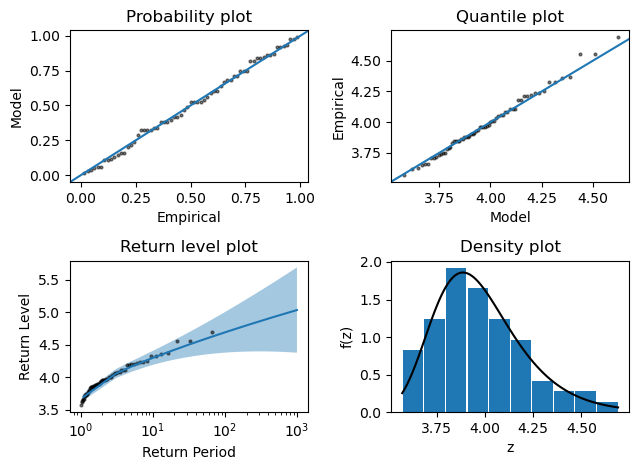

In [3]:
# Load data
data = pd.read_csv(PATH_DATA / "portpirie.csv")
extremes = data["SeaLevel"]# +  np.random.normal(10000, 100000, size=len(data["SeaLevel"]))

# Fit model
model = BlockMaximaModel(max_optim_restarts=1)
model.fit(data=extremes)

# Evaluate
model.diagnostic_plot()

### Example 2: Glass Fiber Strength Example (block minima)

Fitting a GEV model to glass fiber breaking strength data.
Coles (2001) p.64 example 3.4.2.

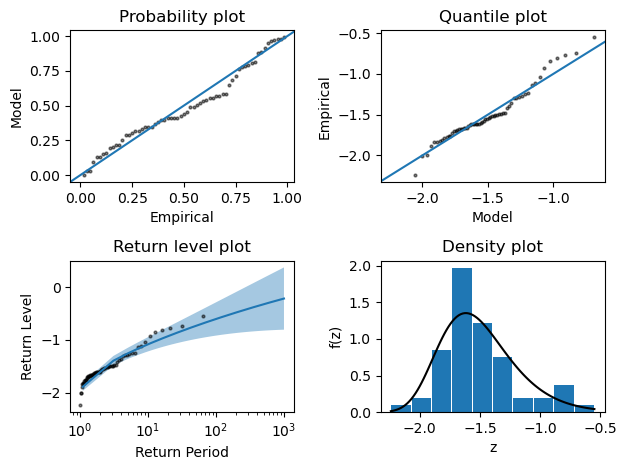

In [4]:
# Load data
data = pd.read_csv(PATH_DATA / "glass.csv")
extremes = -data["Strength"]  # Block minima!

# Fit model
model = BlockMaximaModel(max_optim_restarts=10)
model.fit(data=extremes)

# Evaluate
model.diagnostic_plot()

### Example 3: Daily Rainfall Data

Fitting a GPD model to daily rainfall data.
Coles (2001) p.84 example 4.4.1.

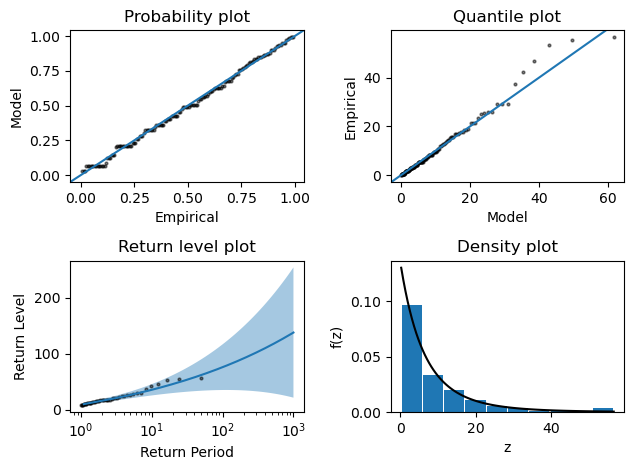

In [5]:
# Load data / define threshold
data = pd.read_csv(PATH_DATA / "rain.csv", parse_dates=[0])
years = {date.year for date in data["Date"]}
num_years = max(years) - min(years) + 1
threshold = 30

# Fit model
model = ThresholdExcessModel(

    max_optim_restarts=10

)
model.fit(    data=data["Rainfall"],
    threshold=threshold,
    num_years=num_years,)

# Evaluate
model.diagnostic_plot()

### Example 4: Dow Jones Index Series

Fitting a GPD model to transformed stock index data.
Coles (2001) p.86 example 4.4.2.

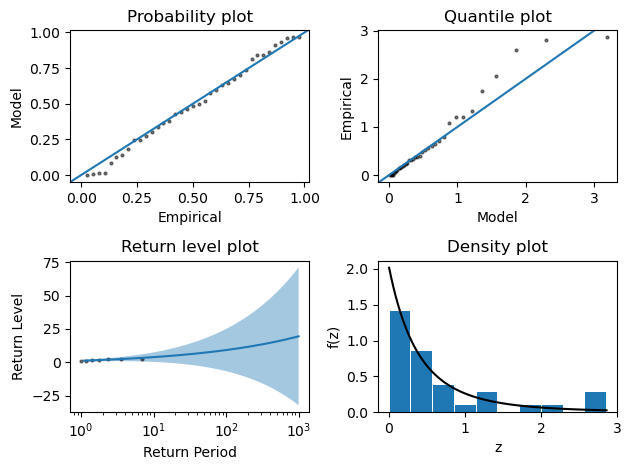

In [6]:
# Load / transform data
data = pd.read_csv(PATH_DATA / "dowjones.csv", parse_dates=["Date"])
years = {date.year for date in data["Date"]}
num_years = max(years) - min(years) + 1
threshold = 2

# Log transformation makes the data approximately stationary.
transdormed_data = 100. * np.diff(np.log(data["Index"]))

# Fit model
model = ThresholdExcessModel(
    
)
model.fit(data=transdormed_data, threshold=threshold, num_years=num_years)

# Evaluate
model.diagnostic_plot()

# automation sandbox

thresh = np.quantile(data["Rainfall"], np.linspace(0.5, 0.98, 50))
mean_distances = np.zeros_like(thresh)
xis = np.zeros_like(thresh)
sigmas = np.zeros_like(thresh)
num_excesses = np.zeros_like(thresh, dtype=int)
seed = 0
rng = np.random.default_rng(seed)

k = 100
m = 500

for i, u in enumerate(thresh):

    extremes = data["Rainfall"][data["Rainfall"] > u].values
    excess = extremes - u
    num_excesses[i] = len(excess)

    if num_excesses[i] < 10:
        continue

    mle_0 = excess.mean()

    model = ThresholdExcessModel(
        data=extremes, threshold=u, num_years=num_years
    )
    model.fit()

    xis[i] = model.theta[0]
    sigmas[i] = model.theta[1]

    distances = np.zeros(k)

    try:
        for j in range(k):

            x = rng.choice(excess, size=num_excesses[i], replace=True)
            mle = x.mean()

            model = ThresholdExcessModel(
                data=x, threshold=u, num_years=num_years
            )
            model.fit()
            quants = model.eval_quantile(np.arange(1, m+1) / (m + 1))

            distances[j] = np.sum(np.abs(np.quantile(x, np.arange(1, m+1) / (m + 1)) - quants)) / m
        mean_distances[i] = distances.mean()
    except:
        mean_distances[i] = np.nan


min_indx = np.argmin(mean_distances[~np.isnan(mean_distances)])
chosen_threshold = thresh[min_indx]
chosen_threshold